<a href="https://www.kaggle.com/code/harishlakshman/cs5661-project?scriptVersionId=234943049" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import pytorch_lightning as pl #to speed up execution
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2) #check if we have GPU's or multiple CPU cores


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishalkundar/gandata20")

print("Path to dataset files:", path)

/kaggle/input/gandata20/birds/test/char-CNN-RNN-embeddings.pickle
/kaggle/input/gandata20/birds/test/64images.pickle
/kaggle/input/gandata20/birds/test/256images.pickle
/kaggle/input/gandata20/birds/train/char-CNN-RNN-embeddings.pickle
/kaggle/input/gandata20/birds/train/64images.pickle
/kaggle/input/gandata20/birds/train/256images.pickle
Path to dataset files: /kaggle/input/gandata20


In [4]:
import pickle

# Sample data
data = {'a': 1, 'b': [2, 3, 4], 'c': 'hello'}

# Pickling (serializing) and saving to a file
with open('data.pickle', 'wb') as file:
    pickle.dump(data, file)

# Unpickling (deserializing) from a file
with open('data.pickle', 'rb') as file:
    loaded_data = pickle.load(file)

print(loaded_data)

{'a': 1, 'b': [2, 3, 4], 'c': 'hello'}


In [3]:
def displaySingleImage(X_train, y_train):
    plt.imshow(X_train[0], cmap="gray")
    plt.title(f"Label: {y_train[0]}")

In [4]:
def check_type(variable):
    if isinstance(variable, np.ndarray):
        return "NumPy array"
    elif isinstance(variable, pd.DataFrame):
        return "Pandas DataFrame"
    else:
        return "Neither NumPy array nor Pandas DataFrame"

In [5]:
with open("/kaggle/input/gandata20/birds/train/64images.pickle", "rb") as file:
    low_res_Xtrain = pickle.load(file)
file.close()    
print(low_res_Xtrain[0])    

[[[147 138 110]
  [169 159 142]
  [174 164 149]
  ...
  [156 144 126]
  [145 133 115]
  [154 149 135]]

 [[111 100  57]
  [111 103  59]
  [129 118  82]
  ...
  [135 126  90]
  [130 124  89]
  [128 118  94]]

 [[115 106  63]
  [117 102  63]
  [141 129 101]
  ...
  [139 131 101]
  [145 135 111]
  [139 130 117]]

 ...

 [[122 110  76]
  [132 122  82]
  [143 133  99]
  ...
  [149 142 125]
  [147 138 125]
  [147 140 121]]

 [[169 152 141]
  [134 119  99]
  [160 153 126]
  ...
  [149 139 128]
  [122 112  94]
  [121 113  81]]

 [[151 142 125]
  [156 145 134]
  [151 136 126]
  ...
  [121 111  91]
  [112  95  70]
  [103  89  57]]]


In [7]:
a = low_res_Xtrain['labels']

TypeError: list indices must be integers or slices, not str

In [ ]:
   
#print(low_res_ytrain[0])
# Try loading with latin1 encoding
try:
    with open("/kaggle/input/gandata20/birds/train/char-CNN-RNN-embeddings.pickle", 'rb') as f:
        low_res_ytrain = pickle.load(f, encoding='latin1')
except UnicodeDecodeError:
    # If latin1 fails, try bytes encoding
    with open("/kaggle/input/gandata20/birds/train/char-CNN-RNN-embeddings.pickle", 'rb') as f:
        low_res_ytrain = pickle.load(f, encoding='bytes')
        # Depending on the data structure, you might need to decode the keys and values
        # Example:
        # data = {k.decode('utf-8'): v.decode('utf-8') for k, v in data.items()}
f.close()   

print(low_res_ytrain[0])


In [ ]:
print(len(low_res_ytrain))

In [ ]:
type(low_res_ytrain)

In [ ]:
low_res_ytrain_np = np.array(low_res_ytrain)
low_res_ytrain_np.shape

In [ ]:
first_image = low_res_ytrain_np[0]
first_caption_embedding = first_image[0]
print("First image, first caption embedding: ", first_caption_embedding)
low_res_ytrain_np_flat = low_res_ytrain_np.reshape(8855,-1)
df = pd.DataFrame(low_res_ytrain_np_flat)
df.head(5)

In [6]:
print('64images type : ', check_type(low_res_Xtrain))
print('length of list: ', len(low_res_Xtrain))

64images type :  Neither NumPy array nor Pandas DataFrame
length of list:  8855


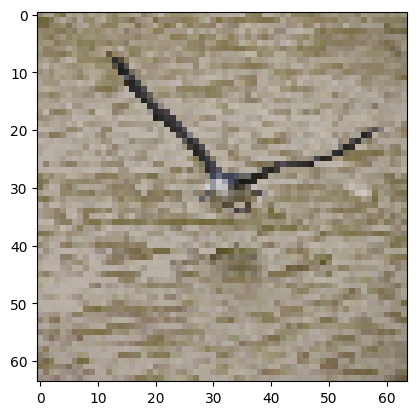

In [7]:
plt.imshow(low_res_Xtrain[0], cmap="gray")

## Create a class that inherits from Pytorch lightning data module.
## Responsible for creating data loaders for training, validation & test set

In [ ]:
class PickleImageDataset(Dataset):
    def __init__(self, pickle_path, tranform=None):
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
        self.images = data
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        #convert to tensor if not already
        if isinstance(img, np.ndarray):
            img = torch.tensor(img, dtype=torch.float32).permute(2,0,1) / 255.0

        if self.transform:
            img = self.transform(img)
        return img

            



class BIRDSDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.data_dir = data_dir #initalize class data with dataset
        self.batch_size = batch_size #initalize class data batch size
        self.num_workers = num_workers #assigns cpu cores

        #defines class tranformation methods
        #Tensors are similar to NumPy arrays, but tensors have accelerator support. 
        #Tensors are optimized for automatic differentiation.
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(), #transforms images to tensors.
                transforms.Normalize((0.1307,), (0.3081,)), #tranformed data is normalized. Ex: 0.1307 = mean; 0.3081 = std deviation
            ]
        )

        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True) #download training data
        MNIST(self.data_dir, train=False, download=True)#download testing data

    # Assign train/val datasets for use in dataloaders
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    #Training
    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )
    #Validation
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)
    #Testing
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

## Download the datset

## split the data into training & validation

### BUILD THE GENERATOR
#### Generate fake data from random noise

In [ ]:
def build_generator():

### BUILD THE DISCRIMINATOR
#### Distinguish between real and fake data

In [ ]:
def build_discriminator():

### 